In [1]:
try:
    import pytorch_lightning
except ImportError as e:
    print ('Installing PyTorch')
    !pip install pytorch-lightning==1.2.8 --quiet # module doesn't exist, deal with it.

    
try:
    import transformers
except ImportError as e:
    print ('Installing Transformers')
    !pip install transformers==4.5.1 --quiet --quiet # module doesn't exist, deal with it.


!pip install gdown

# Multi-class classification of text for toxity types detection using BERT and PyTorch

Multi-label text classification (or tagging text) is one of the most common tasks you'll encounter when doing NLP. Modern Transformer-based models (like BERT) make use of pre-training on vast amounts of text data that makes fine-tuning faster, use fewer resources and more accurate on small(er) datasets.

In this tutorial, you'll learn how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use area under the ROC and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Will our model be any good for toxic text detection?

- Read the tutorial
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [26]:
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 89

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 89


89

In [3]:
data_folder="data"
check_existance = os.path.exists(data_folder)

if not check_existance:
  
  # Create a new directory because it does not exist 
  os.makedirs(data_folder)
  print("The new directory is created!")
    
file_name='data/toxicity_data.csv'

In [4]:
if os.path.exists(file_name):
    pass
else:
    !gdown  -O 'data/toxicity_data.csv' 1jAYm3s71YxEcoO8vNPdwAw7T1uxgX5ss

In [5]:
df = pd.read_csv(file_name)
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


### Split into training and validation

Let's divide data into training and validation:

In [6]:
train_df, val_df = train_test_split(df, test_size=0.2)
train_df.shape, val_df.shape

((127656, 8), (31915, 8))

# Data Analysis

Let's look at the distribution of the labels:

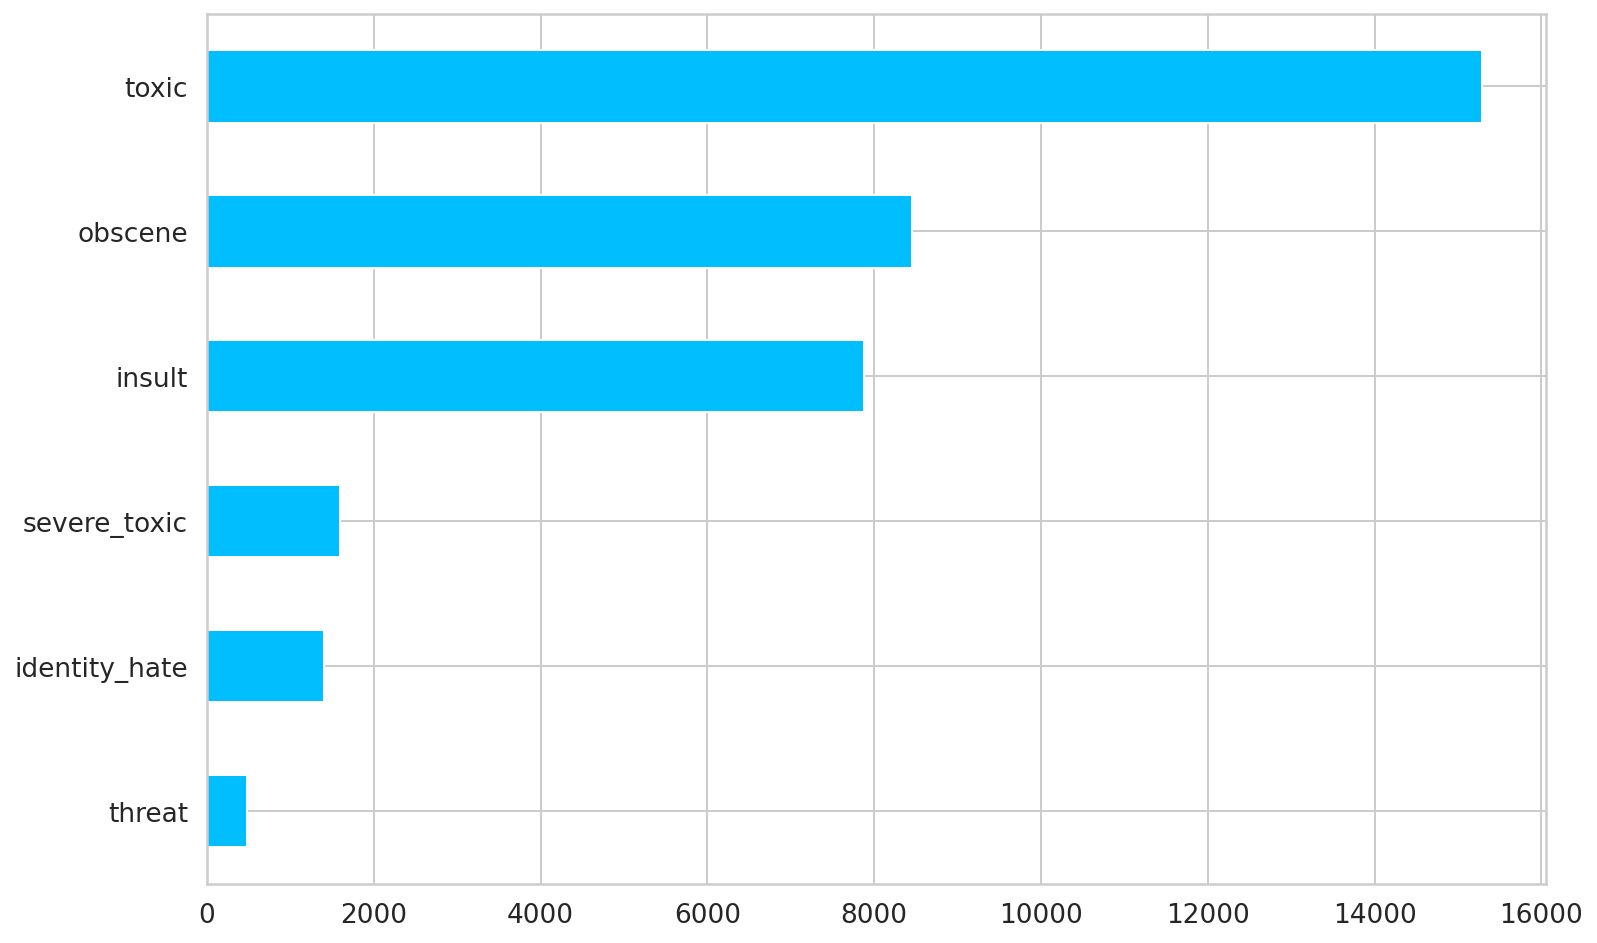

In [7]:
cols = df.columns.tolist()[2:]
df[cols].sum().sort_values().plot(kind="barh");

It is evident from the above plot that this data is highly imbalanced. 
Let's see the ratio of toxic vs non-toxic data:

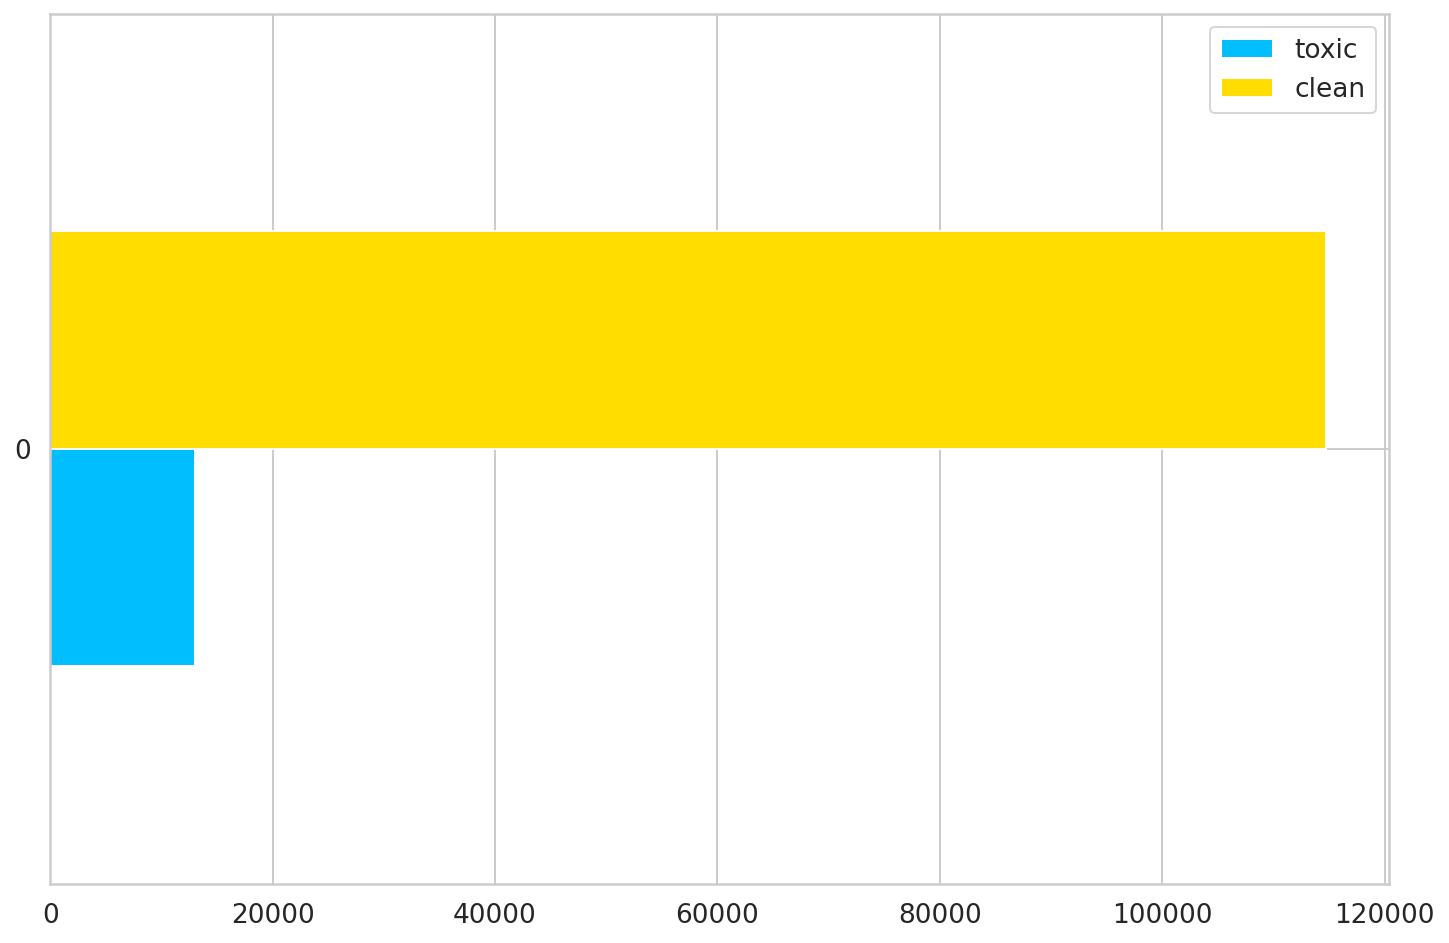

In [8]:
train_toxic = train_df[train_df[cols].sum(axis=1) > 0]
train_clean = train_df[train_df[cols].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(train_toxic)], 
  clean=[len(train_clean)]
)).plot(kind='barh');

Again, we have a severe imbalance in favor of the clean comments. Now there are differnet techniques to deal with imbalance data but since purpose of this tutorial is not to go into details of such methods so we will simply downsample the non-toxic data samples. We will sample 15,000 examples from the clean comments and create a new training set:

In [9]:
train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((27981, 8), (31915, 8))

## Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [10]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [11]:
sample_row = df.iloc[0]
sample_comment = sample_row.comment_text
sample_labels = sample_row[cols]

print(sample_comment)
print()
print(sample_labels.to_dict())

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

{'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [12]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [13]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [14]:
encoding["input_ids"].squeeze()[:50]

tensor([  101, 16409,  1643, 20592,  2116,  2009,  1103, 14609,  1116,  1189,
         1223,  1139,  4795, 16124,  9322,  9475,  9953,  9538, 16061,  1127,
        17464,   136,  1220,  3920,   112,   189,  3498,  6919, 16762,   117,
         1198,  8354,  1113,  1199, 20173,  1116,  1170,   146,  4751,  1120,
         1203,  1365, 25137,  1116,  6820,  1658,   119,  1262,  4268,  1274])

In [15]:
encoding["attention_mask"].squeeze()[:50]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

We can also inverse the tokenization and get back the words from the token ids:

In [16]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:50])

['[CLS]', 'Ex', '##p', '##lana', '##tion', 'Why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'Hard', '##core', 'Metal', '##lica', 'Fan', 'were', 'reverted', '?', 'They', 'weren', "'", 't', 'van', '##dal', '##isms', ',', 'just', 'closure', 'on', 'some', 'GA', '##s', 'after', 'I', 'voted', 'at', 'New', 'York', 'Doll', '##s', 'FA', '##C', '.', 'And', 'please', 'don']


BERT use three embeddings to compute the input representations. They are token embeddings, segment embeddings and position embeddings. “CLS” is the reserved token to represent the start of sequence while “SEP” separate segment (or sentence)

In [17]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:100])

['[CLS]', 'Ex', '##p', '##lana', '##tion', 'Why', 'the', 'edit', '##s', 'made', 'under', 'my', 'user', '##name', 'Hard', '##core', 'Metal', '##lica', 'Fan', 'were', 'reverted', '?', 'They', 'weren', "'", 't', 'van', '##dal', '##isms', ',', 'just', 'closure', 'on', 'some', 'GA', '##s', 'after', 'I', 'voted', 'at', 'New', 'York', 'Doll', '##s', 'FA', '##C', '.', 'And', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', "'", 'm', 'retired', 'now', '.', '89', '.', '205', '.', '38', '.', '27', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


We can see that when we tried to see 100 tokens, it appended 'PAD' as total number of tokens were less than 100. 

We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per comment:

In [18]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["comment_text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

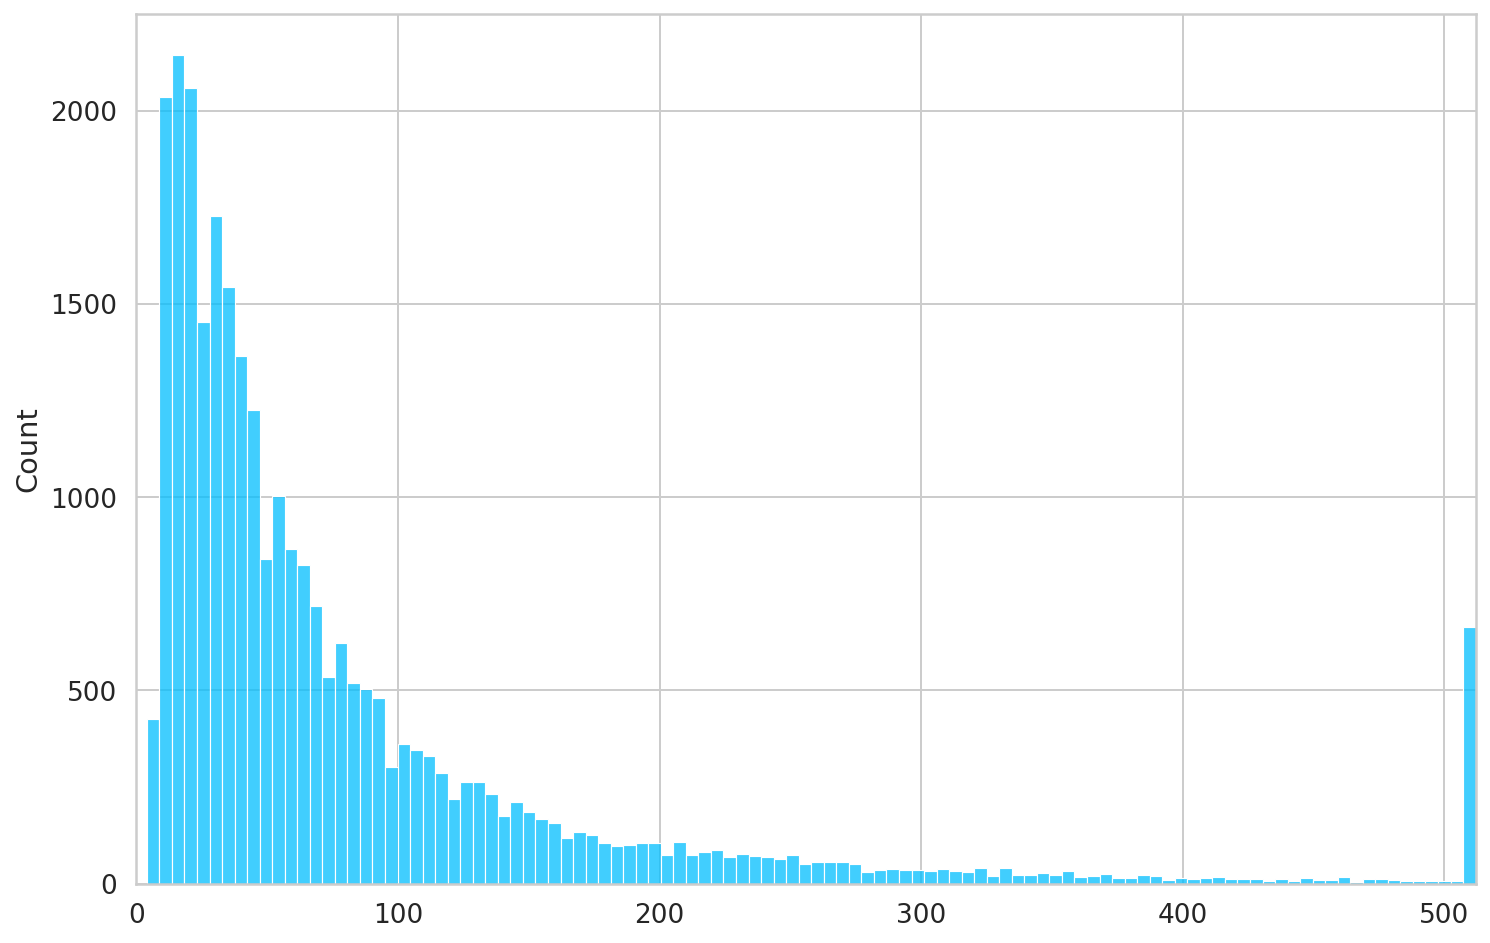

In [19]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

Most of the comments contain less than 300 tokens or more than 512. So, we'll stick with the limit of 512.

In [20]:
MAX_TOKEN_COUNT = 512

Let's apply the tokenization process to whole dataset:

In [23]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row[cols]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let's have a look at a sample item from the dataset:

In [33]:
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[2]
sample_item.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'labels'])

In [34]:
sample_item["comment_text"]

'"IF YOU DONT LIKE ME LEAVING NASTY MESSAGES AND DEFACING YOUR TALK PAGE, THEN STOP DELETING ARTICLES THAT YOU PERSONALLY, UNILATERALLY DECIDE ARE ""IRRELEVANT"" , DO NOT DELETE JESSE MCGRAW AGAIN, ALL INFORMATION IS RELEVANT, NOT JUST THE INFORMATION YOU BELIEVE YOU HAVE THE RIGHT TO PICK AND CHOOSE WHAT GETS PRESERVED, WHO DO YOU THINK YOU ARE? YOU FVCKING AS5H0LE\n"'

In [35]:
sample_item["labels"]

tensor([1., 0., 1., 0., 1., 0.])

In [36]:
sample_item["input_ids"].shape

torch.Size([512])

Let's load the BERT model and pass a sample of batch data through:

In [37]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [38]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 512]), torch.Size([8, 512]))

In [39]:
137662.04 +14774.52 + 48000 + 20000  +100000 + 8095.1 +100275.35 +48000 +43919.68 +112645.34 +116098.15 + 157439.89 


906910.0700000001

In [40]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [41]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 512, 768]), torch.Size([8, 768]))

The `768` dimension comes from the BERT hidden size:

In [43]:
bert_model.config.hidden_size

768

The larger version of BERT has more attention heads and a larger hidden size.

We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html):

In [44]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [45]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model Architecure

Our model will use a pre-trained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):

In [47]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

Most of the implementation is just a boilerplate. Two points of interest are the way we configure the optimizers and calculating the area under ROC. We'll dive a bit deeper into those next.

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [49]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

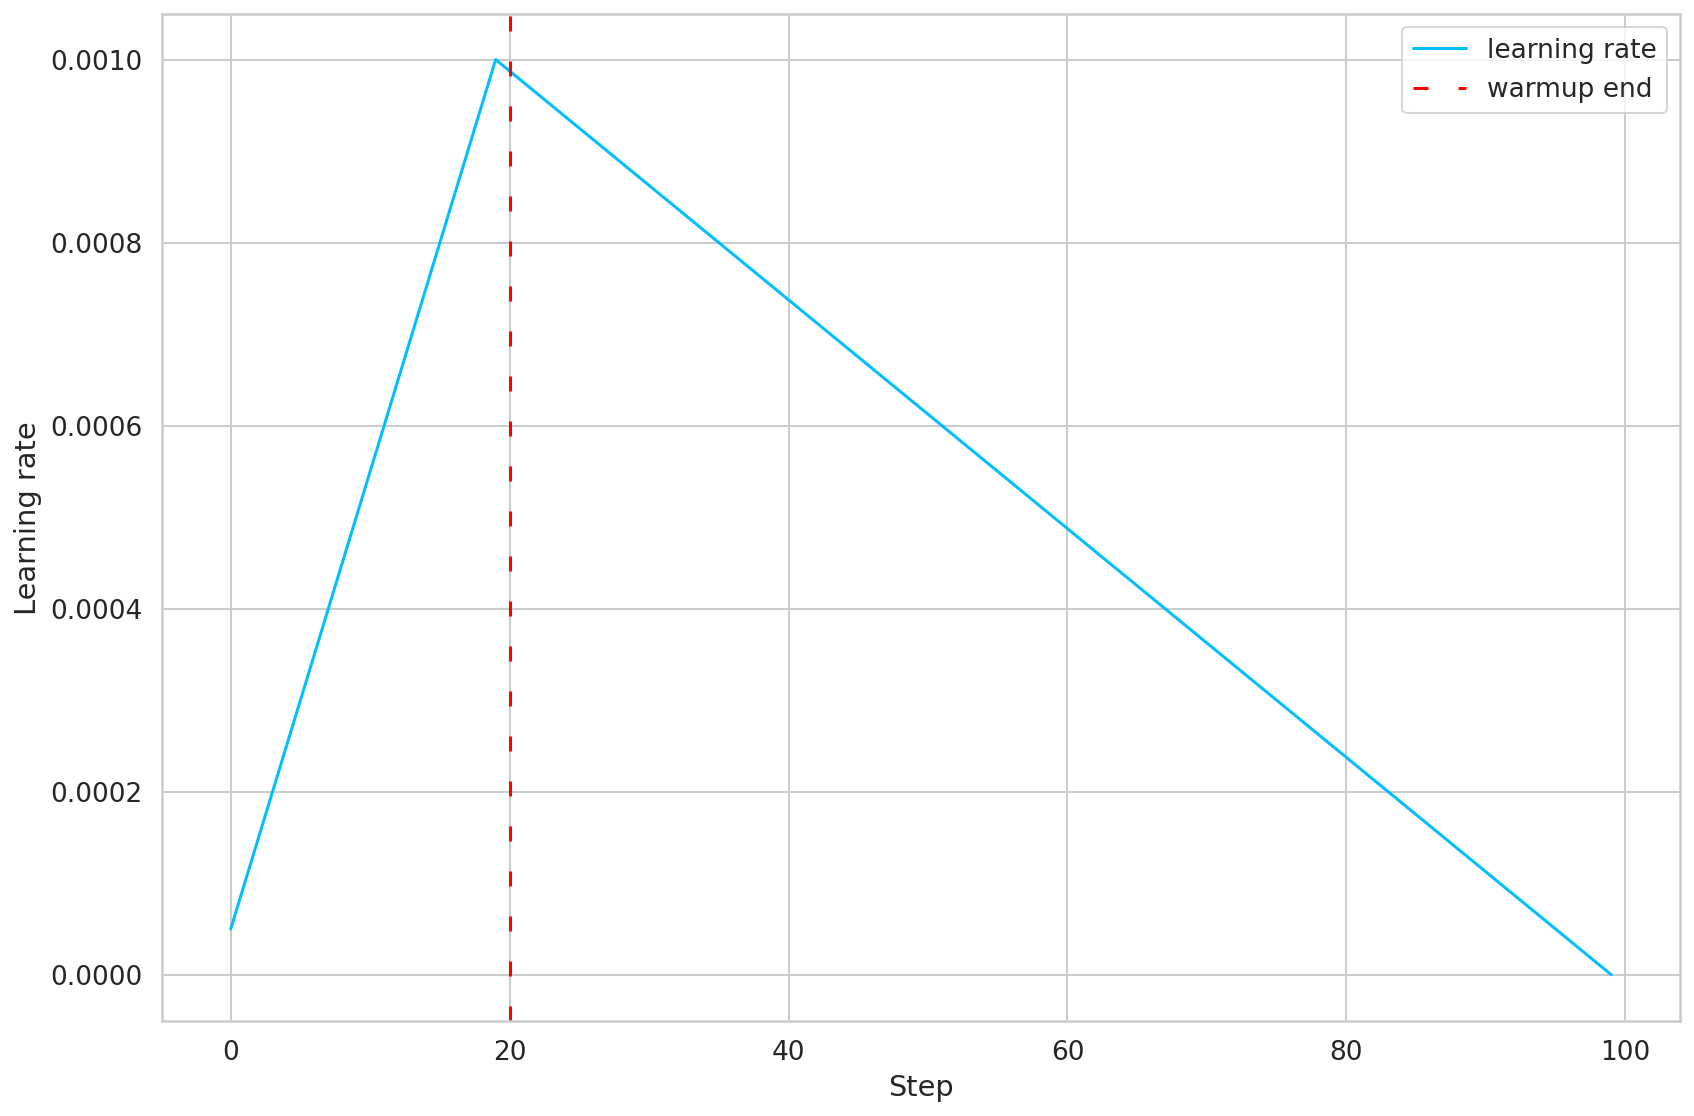

In [50]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to `number of training examples / batch size`. The number of total training steps is `training steps per epoch * number of epochs`:

In [52]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We'll use a fifth of the training steps for a warm-up:

In [53]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(4662, 23310)

We can now create an instance of our model:

In [55]:
model = ToxicCommentTagger(
  n_classes=len(cols),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

### Evaluation

Multi-label classification boils down to doing binary classification for each label/tag.

We'll use Binary Cross Entropy to measure the error for each label. PyTorch has [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which we're going to combine with a sigmoid function (as we did in the model implementation). Let's look at an example:

In [56]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0.]
) 

In [57]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493])

In [58]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.8725)

We can use the same approach to calculate the loss of the predictions:

In [60]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.5991, 0.4031, 0.4493, 0.4934, 0.4473, 0.2914],
        [0.5913, 0.4259, 0.4374, 0.4965, 0.4378, 0.2948],
        [0.5527, 0.4450, 0.4985, 0.5203, 0.4136, 0.2907],
        [0.5871, 0.4053, 0.4284, 0.4973, 0.4305, 0.3079],
        [0.6228, 0.4280, 0.4482, 0.4802, 0.4563, 0.3082],
        [0.6025, 0.4224, 0.4259, 0.4874, 0.4574, 0.3034],
        [0.6109, 0.4190, 0.4488, 0.4897, 0.4769, 0.3001],
        [0.6080, 0.4113, 0.4587, 0.4796, 0.4724, 0.3083]],
       grad_fn=<SigmoidBackward0>)

In [61]:
criterion(predictions, sample_batch["labels"])

tensor(0.5744, grad_fn=<BinaryCrossEntropyBackward0>)

#### ROC Curve

Another metric we're going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} \text{+} \text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} \text{+} \text{TN}}
$$


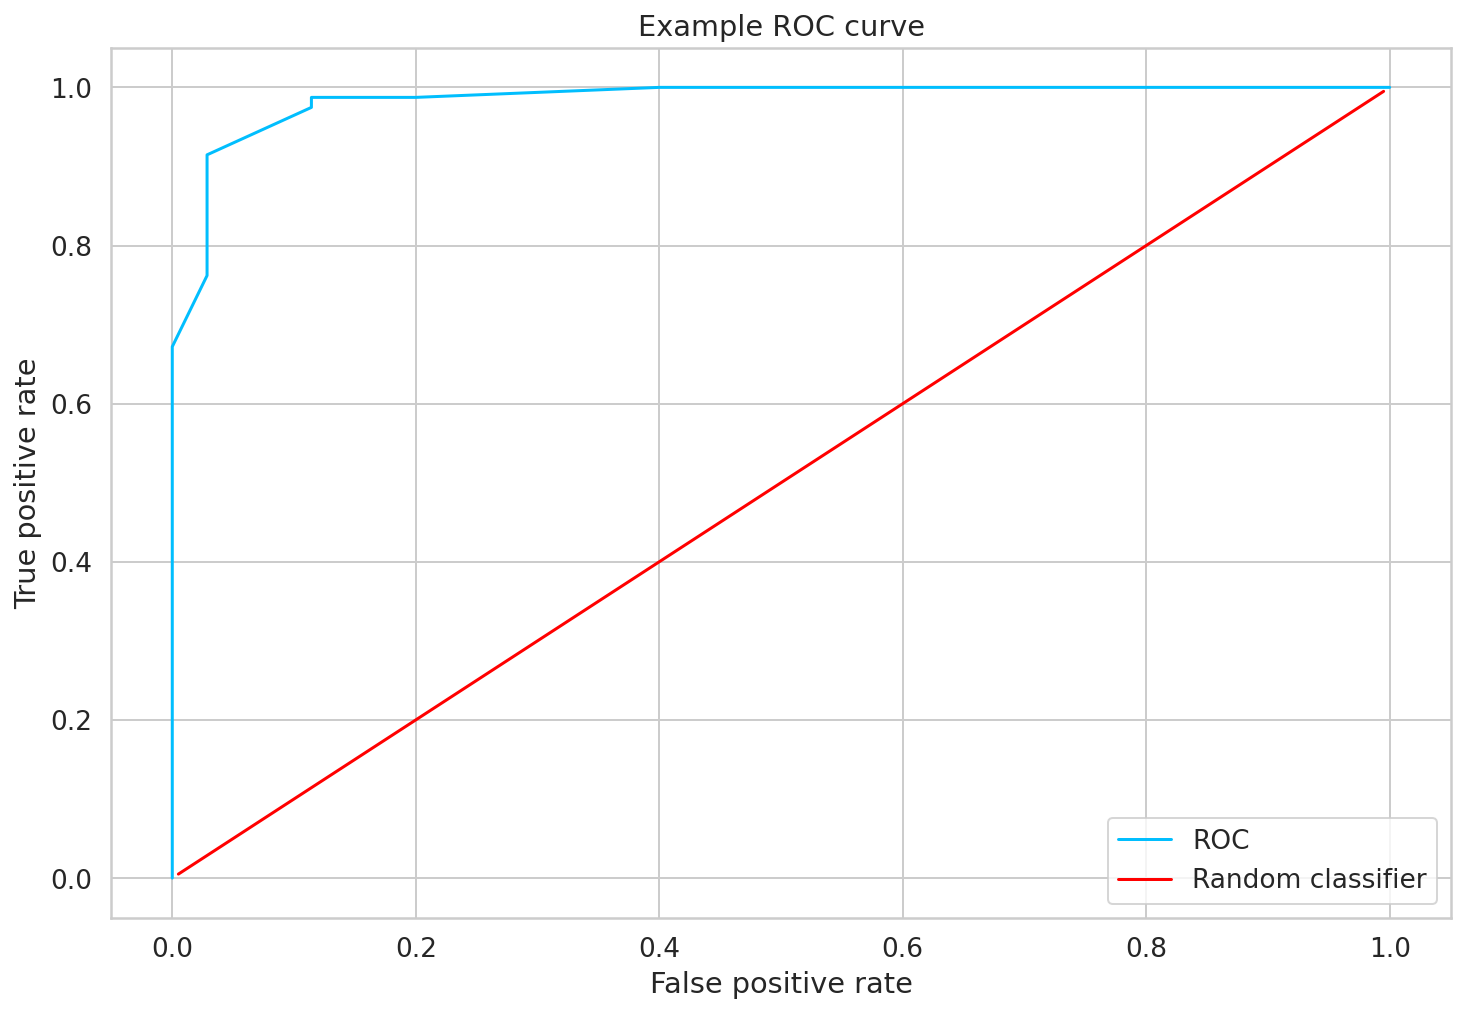

In [63]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

## Training

In [64]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [65]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):

In [66]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

Log the progress in TensorBoard:

In [67]:
logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

And early stopping triggers when the loss hasn't improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [68]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [69]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [70]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 4.6 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.260   Total estimated model params size (MB)
/home/hafsa/anaconda3/envs/py37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/hafsa/anaconda3/envs/py37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 1.96 GiB total capacity; 1.28 GiB already allocated; 116.12 MiB free; 1.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF